# Comparison against hand-crafted hierarchy $p(m|w), p(a|m)$

Hand-craft models $p(a|m)$ for each group of animals. Additionally hand-craft a model selection mechanism $p(m|w)$. The models are used in a hierarchical fashion to narrow down the search space of a low-level bounded rational decision-maker $p(a|m,w)$ that uses the high-level $p(a|m)$ as a prior.

$w$ is the true size of an animal, animals come in three different size-groups - each group has three members.
*  G1: Small: 2,3,4
*  G2: Medium: 6,7,8
*  G3: Large: 10,11,12

Three models: $m_1, m_2, m_3$ corresponding to small, medium-sized and large animals respectively.

The model selection $p(m|w)$ deterministically maps animals to the correct model (using a modulo operation).  
The models are defined as follows:
*  $m_1$: uniform distribution over $a \in \{\text{sneak up }w_2, \text{sneak up }w_3, \text{sneak up }w_4 \}$
*  $m_2$: uniform distribution over $a \in \{\text{sneak up}, \text{ambush}\}$
*  $m_3$: Kronecker delta on $a = \text{flee}$

Since the probabilities for other actions are zero, the models induce a hard partitioning of the action-space.

In [1]:
using Distances, DataFrames, Color, Gadfly, Distributions, Interact, Reactive

include("BlahutArimoto.jl")
include("InformationTheoryFunctions.jl")
include("ConversionFunctions.jl")
include("VisualizationFunctions.jl")
include("ThreeVariableBlahutArimoto.jl")

#make the default plot size a bit larger
set_default_plot_size(15cm, 12cm)

## Utility U(a,w)

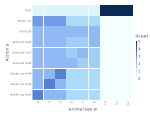

In [2]:
#set up predator-prey example
include("PredatorPreyExample.jl")
w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example()
#w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example(mating_utility=true)


numa = length(a_strings)
a_vec = [1:numa]

numw = length(w_strings)
w_vec = [1:numw]

#pre-compute utility
U_pre, Umax = setuputilityarrays(a_values,w_values,U)

#visualize utility

plt_utility = visualizeMatrix(U_pre, w_values, a_values, w_strings, a_strings, xlabel="animal size w",
                              ylabel="Action a", legendlabel="U(a,w)")

Possible kinds of **animals**:
*  Small animals (w={2,3,4})
  * Can't hear well - sneaking up on them is very likely succesful
  *  The generic sneak-up pattern works very well
  *  An ambush also works but bears the risk that the animal is not moving towards you
  * For each w2, w3, w4 there is a specific sneak-up pattern that increases chances of success for that particular kind of animal - however, using it on the wrong animal, the success rate will be 20% lower  
*  Medium-sized animals (w={6,7,8})
  *  Can hear well - sneaking up on them has lower chances of success compared to ambush
  *  The generic ambush pattern works well but bears the risk that the animal is not moving towards you
  *  A sneak up might also work but chances are quite low
  *  There are specific ambush patterns for w6, w7, w8 but using them has no advantage over the generic ambush, however using them on the wrong animal, the sucess rate will be 20% lower 
*  Large animals (w={10,11,12})
  *  Can potentially kill you, your chances of survival are low if you sneak up or ambush them (no matter with which kind of pattern)
  *  If you flee, your chances of survival are quite good
  
  
Possible kinds of **actions**:
*  Generic *Ambush*: wait for the animal to get close and then strike
  *  advantage: causes no noise
  *  disadvantage: animal might not come towards you
*  Generic *Sneak up*: slowly move closer to the animal and then strike
  *  advantage: works also if animal is not moving towards you
  *  disadvantage: animal might hear or you and flee
*  Generic *Flee*: run away from animal
  *  advantage: if animal could kill you, your chances of survival are significantly increased
  *  disadvantage: if animal was potential prey you missed out on food
*  Specific *Sneak up* for w={2,3,4}: specific sneak up pattern that increases success when applied to exactly the right kind of animal, but decreases success when applied to another animal within the small animal group. When applied to an animal from the medium-sized animal group, the success-rate is equal to the generic sneak up pattern.
*  Specific *Ambush* for w={6,7,8}: does not increase success compared to generic ambush pattern, but decreases success when applied to another animal within the medium-sized group. When applied to an animal from the small group, the success-rate is equal to the generic ambush pattern. As there is no advantage of the specific pattern over the genric pattern (but it might be disadvantegous when applied to the wrong animal), any bounded-rational decision-maker should assign no probability mass to these specific ambush patterns since using them would not increase the expected utility but would increase the informational cost.


  
  
Compared to the generic sneak-up and ambush patterns, the specific pattern require more computational resources, that is they require a larger capacity on the action-channel, or in other words: they require good motor skills and a good motor hardware (which is more costly than a cheap motor system).

If you have bad motoric hardware, you'll never be able to use the specific hunting patterns, therefore it doesn't make sense to waste resources on an expensive perceptual system that allows you to precisely distinguish individual animals. Rather a system that allows you to tell the different groups from each other suffices. Dually, if your perceptual system does not allow you to distinguish between the individual animals, it would be lavish to have an expensive motor system that allows you to accurately execute very specific hunting patterns.

## Hand-crafted hierarchy $p(m|w), p(a|m)$

In [3]:
#set up a hand-crafted model selector p(m|w)
function pmgw_handcrafted(w_values)
    m = div(w_values-2,4)+1
    
    n_m = length(unique(m))
    #initialize with eps() to make sure all values are nonzero
    pmgw = zeros(n_m, length(w_values)) + eps()
    
    #set correct model index in each column of pmgw
    map((w)->pmgw[m[w],w]=1, 1:length(w_values))
    
    #renormalize
    for j in 1:length(w_values)
        pmgw[:,j] /= sum(pmgw[:,j]) 
    end
    
    return pmgw
end

p_mgw = pmgw_handcrafted(w_values)
m_values = [1:size(p_mgw,1)]
m_vec = [1:size(p_mgw,1)]
m_strings = map((x)->"m"*string(x), m_values)


#set up hand-crafted models p(a|m)
function pagm_handcrafted(a_values, m_values)
    #initialize with eps() to make sure that all values are nonzero
    pagm = zeros(length(a_values), length(m_values)) + eps()
       
    #m1 - uniform over the first three actions: sneak up w2, sneak up w3, sneak up w4
    pagm[1:3,1] = 1
    
    #m2 - uniform over generic actions: sneak up, ambush
    pagm[end-2:end-1,2] = 1
    
    #m3 - delta on: flee
    pagm[end,3] = 1
    
    #renormalize (this will produce uniform columns if length(m_values)>3)
    for m in 1:length(m_values)
        pagm[:,m] /= sum(pagm[:,m])
    end
    
    return pagm
end

p_agm = pagm_handcrafted(a_values, m_values)


#visualize hand-crafted distributions
plot_pmgw = visualizeBAconditional(p_mgw, m_vec, w_vec, m_strings, w_strings,
                                   wlabel="animal size w", alabel="model m", legendlabel="p(m|w)")

plot_pagm = visualizeBAconditional(p_agm, a_vec, m_vec, a_strings, m_strings,
                                   wlabel="model m", alabel="action a", legendlabel="p(a|m)")


display(plot_pmgw)
display(plot_pagm)


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(m|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 m1 
 m2 
 m3 
 
 
 model m

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 model m 
 
 
 m1 
 m2 
 m3 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|m) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

## Set parameters to compare the two cases here:
When changing the parameters make sure to re-run the corresponding cells below - in case of doubt simply re-run all cells below.

In [4]:
#Note that β3 will also be used for the bounded rational decision-maker that
#uses the hand-crafted perception. This should allow for easy comparison of
#the action-channels in both cases (hand-crafted vs. hierarchical case)

#inverse temperatures for hierarchical case
#β1: model selection -> inv. price for I(O;W)
#β2=∞: high-level decision -> inv. price for I(A;O)
#β3: low-level decision 
β1 = 8
β2 = Inf  
β3 = 8;

## Bounded rational decision maker for hand-crafted hierarchy

Options{:Dropdown,ASCIIString}([Input{ASCIIString}] 2,"World state w","2","2",OptionDict({"2","3","4","6","7","8","10","11","12"},{"8"=>"8","4"=>"4","12"=>"12","10"=>"10","2"=>"2","6"=>"6","7"=>"7","11"=>"11","3"=>"3"}))

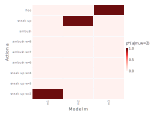

In [17]:
#use hand-crafted model selection p(m|w) and hand-crafted models p(a|m)
#and feed them into a bounded rational decision maker p(a|m,w) using
#p(a|m) as a prior and β3 as inv. temp.

numm = length(m_vec)
numa = length(a_vec)

p_agmw = zeros(numa, numm, numw)

for j in 1:numw
    for m in 1:numm
        p_agmw[:,m,j] = boltzmanndist(p_agm[:,m],β3,U_pre[:,j])
    end
end

#visualize p_agmw
dropdown, plot_pagmw = visualizeBA_double_conditional(p_agmw, a_vec, m_vec,
                                                      a_strings, m_strings, w_strings, 
alabel="Action a", olabel="Model m", legendlabelfunc=(w)->("p*(a|m,w=$w)"))

display(dropdown)
display(plot_pagmw)

In [20]:
#compute p(a|w)
#p(a|w) = ∑_m p(m|w)p(a|m,w)
p_agw_m = zeros(numa, numw)
for j in 1:numw
    p_agw_m[:,j] = p_agmw[:,:,j] * p_mgw[:,j]
end

plot_pagw_m = visualizeBAconditional(p_agw_m, a_vec, w_vec, a_strings, w_strings,
                                     wlabel="animal size w", alabel="action a", legendlabel="p_m(a|w)")


#visualize p(a|w)
display(plot_pagw_m)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p_m(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

In [23]:
#compute p(m)
#p(m) = ∑_w p(m|w)p(w)
p_m = p_mgw * p_w

#compute p(a)
#p(a) = ∑_m p(a|m)p(m)
p_a_m = p_agm * p_m

#compute performance measures of solution
res_m = analyze_three_var_BAsolution(p_w, p_m, p_a_m, p_mgw, p_agm, p_agmw, p_agw_m, U_pre, β1, β2, β3)
perf_df_m = performancemeasures2DataFrame(res_m...)
    
#visualize
p_MI, p_composed, p_perf = plot_three_var_performancemeasures(perf_df_m, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 -2.5 
 0.0 
 2.5 
 5.0 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 -2.5 
 0.0 
 2.5 
 5.0 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 E[U] 
 
 
 
 E[U] 
 1/β1 I(O;W) 
 1/β2 I(A;O) 
 1/β3 I(A;W|O) 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 Utility vs. processing-cost trade-off

## Two-step sequential bounded rational decision maker (perception + action)

#TODO: which initialization is correct?
For low $\beta$, random initializations seem to work better, for high $\beta$ structured initializations seem to work better...

In [8]:
ε = 0.0001 #convergence critetion for BAiterations
maxiter = 5000 #maximum number of BA iterations

#compare the resulting solution against the hierarchical case


#initalize in order to maximize H(O) - i.e. sparse, diagonal initialization
#this is inspired by layer-wise pre-training in stacked auto-encoders, where
#in the unsupervised pre-training step I(O;W) is maximized, keeping in mind that
#in a deterministic model H(O|W) is fixed.
#What could be a justification for doing this?
#
#alternatively, instead of maximizing H(O) try to set I(O;W) exactly at the limit
#that you later impose (however, this is technically difficult, since we only know
#the inv. temperature and not the exact limit on I)
#
#this doesn't seem to help, but it also doesn't seem to hurt... (and in cases
#where you don't have the hand-crafted perceptual model, this could be used)
#TODO: perhaps randomly re-shuffle columns, such that different initializations
#could in principle lead to different solutions
#TODO: perhaps also try initializing p(a|o)?
#
#if(numw<=numo)
#    pogw_init = eye(numo,numw)
#else
#    for b in numo:numo:numw
#        display(b)
#        if b==numo
#            pogw_init = eye(numo, numo)
#        else
#            pogw_init = [pogw_init eye(numo,b-size(pogw_init,2))]
#        end
#    end
#    extra = numw - size(pogw_init,2)
#    if extra>0
#        pogw_init = [pogw_init eye(numo,extra)]
#    end
#end
#pogw_init += rand(size(pogw_init)) * 0.01  #TODO: this factor depends on the number of rows in pogw_init... fix this!
#for j in 1:numw
#    pogw_init[:,j] /= sum(pogw_init[:,j])
#end



#initialize p(o|w) randomly
#pogw_init = rand(numo, numw)
#initialize p(o|w) uniformly
#pogw_init = ones(numo, numw)
#normalize
#for j in 1:numw
#    pogw_init[:,j] /= sum(pogw_init[:,j])
#end


#initialize p(a|o,w) randomly
p_agow_init = rand(numa, numo, numw)
#initialize p(a|o,w) uniformly
#p_agow_init = ones(numa, numo, numw)
#normalize
for j in 1:numw
    for k in 1:numo
        p_agow_init[:,:,j] /= sum(p_agow_init[:,:,j])
    end
end   


#This function performs Blahut-Arimoto iterations for the three-variable general case
po, pa, pogw, pago, pagow, pagw, performance_df = threevarBAiterations(pogw_init, p_agow_init,
                                                  β1, β2, β3, U_pre, p_w, ε, maxiter,
                                                  compute_performance=true, performance_as_dataframe=true);

LoadError: p_ogw_hc not defined
while loading In[8], in expression starting on line 10

In [9]:
#call the routine that creates plots for all the probability distributions
plt_po, plt_pa, plt_pogw, plt_pago, plt_pagw, dpdown, plt_pagow_vis = visualize_three_var_BAsolution(po, pa,
                                                                      pogw, pago, pagow, pagw,
                                                                      o_vec, a_vec, w_vec,
                                                                      o_strings, a_strings, w_strings, 
                                                                      olabel_string="o", alabel_string="a", wlabel_string="w")

#visualize p(o|w)
display(plt_pogw)
#visualize p(a|o)
display(plt_pago)
#visualize p(a|w)
display(plt_pagw)

LoadError: po not defined
while loading In[9], in expression starting on line 2

In [10]:
p_MI, p_composed, p_perf = plot_three_var_performancemeasures(performance_df, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

LoadError: performance_df not defined
while loading In[10], in expression starting on line 1

## Compare hand-crafted $p(o|w,\lambda)$ vs. bounded-optimal $p^*(o|w)$

In [11]:
#compare both solutions

#compare performance measures, EU, J, I(A;W)

util_all = [perf_df_hc[end,:E_U], performance_df[end,:E_U],
            perf_df_hc[end,:Objective_value], performance_df[end,:Objective_value]]

color_label = ["E[U]_hc", "E[U]", "J_hc", "J"]

colors = BAdiscretecolorscale(4).f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[end],colors[end])

p_perf_comp = plot(x=color_label, y=util_all, color=color_label, Geom.bar(),
                   Guide.ylabel("[utils]"), Guide.xlabel(""), Guide.colorkey(""),
                   Guide.title("λ=$λ vs. β1=$β1, β2=$β2, β3=$β3"),
                   colscale, Scale.y_continuous(minvalue=0, maxvalue=maximum(U_pre)),
                   BAtheme(key_position = :none))


MI_comp = [perf_df_hc[end,:I_ow], performance_df[end,:I_ow],
           perf_df_hc[end,:I_ao], performance_df[end,:I_ao]]
color_label = ["I(O;W)_hc", "I(O;W)", "I(A;O)_hc", "I(A;O)"]

colors = Scale.color_discrete_hue().f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[2],colors[2])

p_perf_comp_MI = plot(x=color_label, y=MI_comp, color=color_label, Geom.bar(),
                      Guide.ylabel("[bits]"), Guide.xlabel(""), Guide.colorkey(""),
                      Guide.title("λ=$λ vs. β1=$β1, β2=$β2, β3=$β3"),
                      colscale, Scale.y_continuous(minvalue=0), BAtheme(key_position = :none))

display(hstack(p_perf_comp,p_perf_comp_MI))

LoadError: perf_df_hc not defined
while loading In[11], in expression starting on line 5

In [12]:
#compare final behavior p(a|w) of both cases
display(plt_pagw_hc)
display(plt_pagw)

LoadError: plt_pagw_hc not defined
while loading In[12], in expression starting on line 2

In [13]:
#compare perceptual model p(o|w) of both cases
display(plt_pogw_hc)
display(plt_pogw)

LoadError: plt_pogw_hc not defined
while loading In[13], in expression starting on line 2

Cases that work nicely:
*  $\lambda=1.65$, $\beta_1 = 8$, $\beta_2 = 10$ (same $I(O;W)$ for both models - almost unbounded actor)
*  $\lambda=0.4$, $\beta_1 = 1$, $\beta_2 = 10$ (same $I(O;W)$ for both models - bounded actor, optimal action changes, given the limits on the perceptual channel)
*  $\lambda=1.65$, $\beta_1 = 8$, $\beta_2 = 1$ (same EU - bounded actor, optimal perception changes, given the limits on the action channel)


*  $\lambda=10$, $\beta_1 = 10$, $\beta_2 = 5$, mating-utility (optimal perception changes under a different utility function - compare against case above with identical parameters but different utility function)


Change the temp on the action-channel (with very large resources on the observation channel) and see how the perception is affected by the action.

Change the temp on the perception-channel (with very large resources on the action channel) and see how the action is affected by perception.

Change utility function (mating-utility) and see how the percept is affected by the new utility.

In [14]:
#generate plots for comparison

plot_bars = (vstack(p_perf_comp,p_perf_comp_MI))
plot_final = vstack(hstack(plt_pogw_hc, plt_pagw_hc),hstack(plt_pogw, plt_pagw))
#plot_final = vstack(hstack(plt_pogw_hc, plt_pagw_hc, p_perf_comp),hstack(plt_pogw, plt_pagw, p_perf_comp_MI))

w = 18cm
h = 12cm
#draw(SVG("Figures/SequentialComparison_beta1_1.svg", w, h), plot_final) #uncomment to store figure#
#draw(SVG("Figures/SequentialComparisonBars_beta1_1.svg", 8cm, h), plot_bars) #uncomment to store figure

#draw(SVG("Figures/SequentialComparison_Utility.svg", 10cm, 8cm), plt_utility) #uncomment to store figure


LoadError: p_perf_comp not defined
while loading In[14], in expression starting on line 3

In [15]:
#show that the serial BA case has a higher objective J
#   meaning that information processing resources are wasted - i.e. they could be used to
#   achieve a higher expected utility.

#show that the percept in the serial case is shaped by the utility
#   Putting a lot of resources in veridical reproduction of the worldstate is lavish if
#   the utility does not crucially depend on parts of the world-state

#show that changing the downstream information processing capacity affects the percept
#   Putting tons of resources into the percept is lavish if the downstream processing is poor
#   With the principle, the two (sort of) balance themselves

#change the utility function and show how the optimal percept changes
#(but the fixed likelihood-function stays the same)

In [16]:
#TODO: the problem with comparing against the sequential case might be that the sequential case does
#not converge to a solution where I(O;W) is optimal - perhaps by initializing with one-step BA solution with
#the same temperature, the problem can be alleviated?

#Compute initialization of p(o|w) as solution to one-step BA with same temperature
#TODO: the code for the different initializations should actually be moved into a separate function
#      including the code to initialize p(o|w) with a one-step BA solution
